Les arbres de décision sont des algorithmes de machine learning pouvant être utilisés pour : 
- **Un problème de régression** où la variable à prédire est quantitative (pour prédire par exemple le prix d'une maison)
- **Un problème de classification** où la variable à prédire est qualitative (prédire le spam d'un e-mail)

# Arbre de Decision : Classifieur

Le modèle d'arbre classifieur est un arbre binaire où les prédictions sont faites en parcourant l'arbre de **la racine** à **la feuille**.

Lors du parcours de chaque noeud :

- si une **caractéristique est inférieure à un seuil**, nous allons à gauche, sinon nous allons à droite.
- chaque **feuille est associée à une classe**, qui est la prédiction du modèle.

> On utilisera le jeu de données *iris* pour implémenter le classifieur

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris

In [6]:
iris = load_iris()

X = iris.data
y = iris.target

In [7]:
X = pd.DataFrame(X, columns=iris.feature_names)
y = pd.Series(y, name="y")

L'algorithme utilisé dans un arbre de décision de type classifieur est appelée CART (abréviation de *Classification And Régression Trees*). Cet algorithme consiste de partir de la racine de l'arbre et de trouver le meilleur split successivement pour chaque embranchement (chaque noeud est construit de manière à minimiser l'impureté de Gini des enfants).

La récursivité s'arrête lorsque la profondeur maximale est atteinte, c'est à dire quand plus aucune séparation n'est possible de manière plus pur que le noeud parent. 

*NB : Il est possible de contrôler le critère d'arrêt, crucial en pratique, car il permet d'éviter le surapprentissage.*

## Métrique de split 

Pour les arbres de décisions, on trouve deux types de métrique : 
- **l'indice de gini** : mesure de la purété de l'information
- **l'entropie de Shanon** : mesure du désordre dans un système 

### L'indice de GINI

Les arbres de décision utilisent le concept **d'impureté de Gini** pour décrire à quel point un noeud est *homogène* ou *pur*. 

Un noeud est dit pur $(G = 0)$ si toutes ses observations appartiennent à la même classe, tandis qu'un noeud avec de nombreuses observations de classes différentes aura un Gini proche de 1.

On défini **l'impureté Gini** de $n$ échantillons répartis en $k$ classes par :

$$\text{G} = 1 - \sum_{k=1}^{n}{\left(\frac{s_{k}}{s} \right)^2}$$

où : 
- $s$ correspond à l'échantillon total
- $s_k$ correspond à la part de l'échantillon appartenant à la classe $k$

>On peut par exemple calculer l'indice de Gini sur des données du Dataset *iris*, pour le premier noeud parent

In [8]:
def _gini(y):
    m = y.size
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

In [9]:
_gini(y)

0.6666666666666667

###  l'Entropie de Shanon

**l'Entropie** est une métrique qui mesure le désordre dans un systeme.

...


...

## Embranchements : variables et seuils optimaux

L'objectif de l'algorithme CART est de trouver la variable et le seuil optimal pour que l'impureté de Gini soit minimisée. On parle de la *racine* dans le cas du premier noeud de l'arbre.

Pour ce faire : **il faut calculer l'indice de Gini pour toutes les divisions possibles**. 

- Pour le cas d'une variable expliquée **binaire**, il faut juster compter le nombre de modalité pour le split de cette variable.

- Pour une valeur **continue**, il faut au préalable trier les valeurs et utiliser comme seuil tous les points médians entre deux valeurs adjacentes.

### Thresholds

> On considère une variable du jeu de données et on récupère toutes les valeurs possibles

In [10]:
t = X["petal length (cm)"].unique()
t

array([1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1. , 1.9, 4.7, 4.5, 4.9, 4. ,
       4.6, 3.3, 3.9, 3.5, 4.2, 3.6, 4.4, 4.1, 4.8, 4.3, 5. , 3.8, 3.7,
       5.1, 3. , 6. , 5.9, 5.6, 5.8, 6.6, 6.3, 6.1, 5.3, 5.5, 6.7, 6.9,
       5.7, 6.4, 5.4, 5.2])

> Ne pas oublier de trier la liste

In [11]:
def __make_threshold(liste):
    if len(liste) > 1:
        liste_sorted = sorted(liste)
        return np.array([np.mean((liste_sorted[i], liste_sorted[i+1]))
                         for i in range(len(liste_sorted))[:-1]])
    else:
        return np.array(liste)

> On applique la moyenne pour chaque observation deux à deux (sans oublier de retirer la dernière valeur pour éviter de retourner une erreur)

In [12]:
__make_threshold(t)

array([1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.8 , 2.45, 3.15, 3.4 ,
       3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55,
       4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65,
       5.75, 5.85, 5.95, 6.05, 6.2 , 6.35, 6.5 , 6.65, 6.8 ])

### Gini pondéré

Après avoir trouver l'ensemble des seuils possibles pour une variable quanti (c'est aussi le cas pour une variable quali, mais l'arbre gère cela de manière ordinale) il faut maintenant selectionner le meilleur seuil qui minimise **l'indice de Gini pondéré** (entre les deux Gini de chaque embranchement). 


Dans une première étape, il faut calculer l'indice de Gini pour le **noeud fils de gauche et de droite** (il faut obligatoirement une séparation en deux modalités).

Pour le noeud de gauche : 

- $i$ : désigne le nombre d'observations répondant vraie au seuil de la variable
- $s_k^{i}$ : désigne le nombre d'observation répondant au seuil de la variable choisit et à la modalité $k$

$$G^{left}_i = 1 - \sum_{k=1}^{n}{\left(\frac{s_{k}^{i}}{i} \right)^2}$$

De manière symétrique pour le noeud de droite : 

$$G^{right}_i = 1 - \sum_{k=1}^{n}{\left(\frac{s_{k}^{i-}}{i-} \right)^2}$$

*Note : $i-$ correspond à l'inverse du seuil, donc les modalités fausses* 

Dans une deuxième étape il faut maintenant calculer **le gini pondéré** entre les deux noeuds fils pour connaitre le gini de cet embranchement.

$$G_n =  \frac{i}{s} \; G^{left}_i + \frac{i-}{s} \; G^{right}_i $$

> On prend une des variable du jeu de données iris et on calcule l'indice de Gini fils optimal pour chacun des seuils possibles. On peut fixer un seuil arbitraire pour commencer.

In [13]:
def gini_node_child(X, y, var, threshold):
    classe = X[var] < threshold

    m = len(y)
    number_left = sum(classe)
    number_right = sum(~classe)

    gini_left = 1.0 - sum((sum(classe[y == i]) / number_left) ** 2
                          for i in np.unique(y))
    gini_right = 1.0 - sum((sum(~classe[y == i]) / number_right) ** 2
                           for i in np.unique(y))

    gini_pondere = (number_left * gini_left + number_right * gini_right) / m
    return gini_pondere

> Pour la variable *petal length (cm)* on applique le seuil de 4 (toujours inférieur).

In [14]:
gini_node_child(X, y, "petal length (cm)", 4)

0.41235341069564685

On peut maintenant répeter cela pour tous les splits possibles de cette variable : 

In [15]:
liste_gini_pondere = []

for i in __make_threshold(np.unique(X["petal length (cm)"])):
    gini_pondere = gini_node_child(X,y,'petal length (cm)', i)
    liste_gini_pondere.append((gini_pondere, i))

Il est possible d'afficher l'ensemble des Gini pondérés afin de retenir le meilleur seuil de séparation **pour cette variable**.

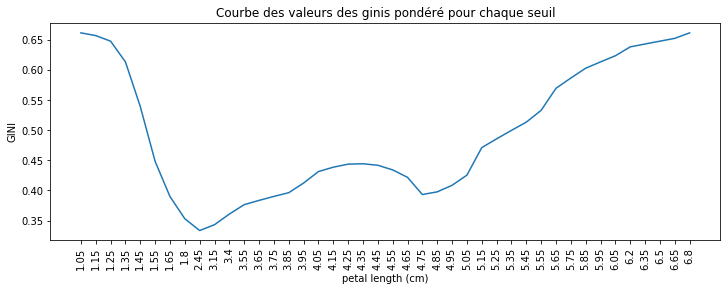

In [16]:
plt.figure(figsize=(12,4))
plt.plot([i[0] for i in liste_gini_pondere])
plt.xticks(ticks=range(len(liste_gini_pondere)),
           labels=[np.round(i[1],2) for i in liste_gini_pondere], 
           rotation='vertical')
plt.xlabel(iris.feature_names[2])
plt.ylabel('GINI');
plt.title('Courbe des valeurs des ginis pondéré pour chaque seuil');

On peut donc voir que le seuil optimal de séparation est : $2.45$. L'indice de Gini associé est inférieur à 0,35. Cependant, il s'agit du meilleur seuil pour cette variable. Il faut donc itérer pour chacune des variables et chercher le meilleur split parmi l'ensemble des variables possibles.

### Échantillon

La troisième étape consiste donc de retenir l'échantillon respectant le split du noeud et appliquer la même méthode pour chaque embranchement de manière successive. La classification consiste à retenir la classe majoritaire au sein d'un noeud.

In [17]:
def sample_node_child(X, y, var, threshold, target_name):

    classe = X[var] < threshold

    m = len(y)
    number_left = sum(classe)
    number_right = sum(~classe)
    
    sample_left_count = {target_name[i]: sum(classe[y == i]) for i in np.unique(y)}
    sample_right_count = {target_name[i]: sum(~classe[y == i]) for i in np.unique(y)}

    sample_left = pd.concat(classe[y == i] for i in np.unique(y))
    sample_right = pd.concat(~classe[y == i] for i in np.unique(y))
    
    return (sample_left_count, sample_left), (sample_right_count, sample_right)

In [18]:
left, right = sample_node_child(X, y, "petal length (cm)", 2.45, iris.target_names)

> On peut afficher la répartition de chaque modalité pour ce split et les index des valeurs respectant cette répartition

In [19]:
left[0]

{'setosa': 50, 'versicolor': 0, 'virginica': 0}

In [20]:
left[1]

0       True
1       True
2       True
3       True
4       True
       ...  
145    False
146    False
147    False
148    False
149    False
Name: petal length (cm), Length: 150, dtype: bool

On peut créer une classe `Node` qui s'occupe de créer les noeuds fils : 

In [115]:
class Node:
    def __init__(self, X, y, var, threshold, target_name):

        classe = X[var] < threshold
        m = len(y)
        number_left = sum(classe)
        number_right = sum(~classe)

        self.threshold = threshold
        self.var = var

        left, right = self._sample_node_child(
            X, y, var, threshold, target_name, classe)

        self.sample_left = left[1]
        self.repartition_left = left[0]

        self.sample_right = right[1]
        self.repartition_right = right[0]

        self.gini_pondere = self._gini_node_child(X, y, var, threshold, classe,
                                                  m, number_left, number_right)

    def _sample_node_child(self, X, y, var, threshold, target_name, classe):
        """
        Recherche de la répartition et des indices des noeuds fils

        Paramètre 
        --------
        X : DataFrame des features (X)
        y : Série de la valeur à prédire (y)
        threshold : seuil de découpage en deux échantillons


        """

        sample_left_count = {target_name[i]: sum(
            classe[y == i]) for i in np.unique(y)}

        sample_right_count = {target_name[i]: sum(
            ~classe[y == i]) for i in np.unique(y)}

        sample_left = pd.concat(classe[y == i] for i in np.unique(y))
        sample_right = pd.concat(~classe[y == i] for i in np.unique(y))

        return (sample_left_count, sample_left), (sample_right_count, sample_right)

    def _gini_node_child(self, X, y, var, threshold, classe, m, number_left, number_right):
        """
        Calcul du gini pondéré entre les deux noeuds fils

        Paramètre
        --------
        X : DataFrame des features (X)
        y : Série de la valeur à prédire (y)
        threshold : seuil de découpage en deux échantillons

        """

        gini_left = 1.0 - sum((sum(classe[y == i]) / number_left) ** 2
                              for i in np.unique(y))
        gini_right = 1.0 - sum((sum(~classe[y == i]) / number_right) ** 2
                               for i in np.unique(y))

        gini_pondere = (number_left * gini_left +
                        number_right * gini_right) / m

        return gini_pondere

On a donc créer une classe `Node` qui prend pour paramètre en entrée les X, la variable y, un seuil et une variable. Lorsqu'elle est instanciée, elle contient comme atributs : 

>- le gini pondéré ; 
>- le seuil de split ;
>- la variable associé au seuil ;  
>- l'échantillon pour le noeud fils gauche et de droite ; 
>- la répartition de gauche et la réparition de droite des fils ;

La fonction suivante permet de trouver le meilleur embranchement possible (itération sur tous les seuls possibles pour chacune des variables)

In [31]:
def find_best_node(X, y, target_name):
    
    best_gini = _gini(y)
    node_parent = None

    for var in X.columns:

        all_value = np.unique(X[var])
        all_treshold = __make_threshold(all_value)

        if len(all_treshold) > 1:
            
            for threshold in all_treshold:
                node = Node(X, y, var, threshold, target_name)

                if node.gini_pondere < best_gini:
                    best_gini = node.gini_pondere
                    node_parent = node

    return node_parent

In [24]:
best_node = find_best_node(X,y, target_name=iris.target_names)

On peut afficher les informations du meilleur noeud de split : 

In [25]:
print(best_node.var)
print(best_node.threshold)

petal length (cm)
2.45


Et la répartition des noeuds fils : 

In [26]:
print(best_node.repartition_left)
print(best_node.repartition_right)

{'setosa': 50, 'versicolor': 0, 'virginica': 0}
{'setosa': 0, 'versicolor': 50, 'virginica': 50}


## Récursivité des noeuds 

La dernière étape de l'algorithme consiste à créer les noeuds de manière sucessive à partir des informations des noeuds fils.

In [88]:
max_depth = float('inf')

In [89]:
def tree_growth(X, y, depth=0, target_name=None):

    if target_name is None:
        target_name = np.unique(y)

    classe_predict = target_name[y[y.idxmax()]]
    repartition_parent = dict(zip(target_name, y.value_counts(sort=False)))

    print('-' * 10)
    print("class : ", classe_predict)
    print("sample : ", repartition_parent)

    if depth < max_depth:
        node = find_best_node(X, y, target_name)

        if node is not None:

            X_left, y_left = X[node.sample_left], y[node.sample_left]
            X_right, y_right = X[node.sample_right], y[node.sample_right]

            print(node.var, "<=", node.threshold)
            print(node.repartition_left)
            print(node.repartition_right)
            node._left = tree_growth(X_left, y_left, depth + 1, target_name)
            node._right = tree_growth(X_right, y_right, depth + 1, target_name)

        return node

In [90]:
tree = tree_growth(X, y, target_name=iris.target_names)

----------
class :  virginica
sample :  {'setosa': 50, 'versicolor': 50, 'virginica': 50}
petal length (cm) <= 2.45
{'setosa': 50, 'versicolor': 0, 'virginica': 0}
{'setosa': 0, 'versicolor': 50, 'virginica': 50}
----------
class :  setosa
sample :  {'setosa': 50}
----------
class :  virginica
sample :  {'setosa': 50, 'versicolor': 50}
petal width (cm) <= 1.75
{'versicolor': 49, 'virginica': 5}
{'versicolor': 1, 'virginica': 45}
----------
class :  virginica
sample :  {'setosa': 49, 'versicolor': 5}
petal length (cm) <= 4.95
{'versicolor': 47, 'virginica': 1}
{'versicolor': 2, 'virginica': 4}
----------
class :  virginica
sample :  {'setosa': 47, 'versicolor': 1}
petal width (cm) <= 1.65
{'versicolor': 47, 'virginica': 0}
{'versicolor': 0, 'virginica': 1}
----------
class :  versicolor
sample :  {'setosa': 47}
----------
class :  virginica
sample :  {'setosa': 1}
----------
class :  virginica
sample :  {'setosa': 2, 'versicolor': 4}
petal width (cm) <= 1.55
{'versicolor': 0, 'virginica

## Création de la classe

In [112]:
class DecisionTreeClassif:

    def __init__(self, max_depth=None):

        if max_depth is None:
            max_depth = float('inf')

        self.max_depth = max_depth

    def fit(self, X, y, target_name=None):

        if target_name is None:
            target_name = np.unique(y)

        self.all_classes = np.unique(y)
        self.tree = self._tree_growth_(X, y, target_name=target_name)

    def _gini_(self, y):
        m = y.size
        return 1.0 - sum((np.sum(y == c) / m) ** 2
                         for c in self.all_classes)

    def __make_threshold__(self, liste):
        liste_sorted = sorted(liste)
        return np.array([np.mean((liste_sorted[i], liste_sorted[i+1]))
                         for i in range(len(liste_sorted))[:-1]])

    def _tree_growth_(self, X, y, target_name, depth=0):

        classe_predict = target_name[y[y.idxmax()]]
        repartition_parent = dict(zip(target_name, y.value_counts(sort=False)))

        print('-' * 10)
        print("class : ", classe_predict)
        print("sample : ", repartition_parent)

        if depth < max_depth:
            node = self._find_best_node_(X, y, target_name)

            if node is not None:

                X_left, y_left = X[node.sample_left], y[node.sample_left]
                X_right, y_right = X[node.sample_right], y[node.sample_right]

                print(node.var, "<=", node.threshold)
                print(node.repartition_left)
                print(node.repartition_right)

                node._left = tree_growth(
                    X_left, y_left, depth + 1, target_name)
                node._right = tree_growth(
                    X_right, y_right, depth + 1, target_name)

            return node

    def _find_best_node_(self, X, y, target_name):

        best_gini = self._gini_(y)
        node_parent = None

        for var in X.columns:

            all_value = np.unique(X[var])
            all_treshold = self.__make_threshold__(all_value)

            if len(all_treshold) > 1:

                for threshold in all_treshold:
                    node = Node(X, y, var, threshold, target_name)

                    if node.gini_pondere < best_gini:
                        best_gini = node.gini_pondere
                        node_parent = node

        return node_parent

In [113]:
clf_ = DecisionTreeClassif()

In [116]:
clf_.fit(X, y, iris.target_names)

----------
class :  virginica
sample :  {'setosa': 50, 'versicolor': 50, 'virginica': 50}
petal length (cm) <= 2.45
{'setosa': 50, 'versicolor': 0, 'virginica': 0}
{'setosa': 0, 'versicolor': 50, 'virginica': 50}
----------
class :  setosa
sample :  {'setosa': 50}
----------
class :  virginica
sample :  {'setosa': 50, 'versicolor': 50}
petal width (cm) <= 1.75
{'versicolor': 49, 'virginica': 5}
{'versicolor': 1, 'virginica': 45}
----------
class :  virginica
sample :  {'setosa': 49, 'versicolor': 5}
petal length (cm) <= 4.95
{'versicolor': 47, 'virginica': 1}
{'versicolor': 2, 'virginica': 4}
----------
class :  virginica
sample :  {'setosa': 47, 'versicolor': 1}
petal width (cm) <= 1.65
{'versicolor': 47, 'virginica': 0}
{'versicolor': 0, 'virginica': 1}
----------
class :  versicolor
sample :  {'setosa': 47}
----------
class :  virginica
sample :  {'setosa': 1}
----------
class :  virginica
sample :  {'setosa': 2, 'versicolor': 4}
petal width (cm) <= 1.55
{'versicolor': 0, 'virginica

## Avec sklearn

In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [118]:
clf = DecisionTreeClassifier(max_depth=5, random_state=100)
clf.fit(X,y);

En haut de l'arbre on trouve la racine : 

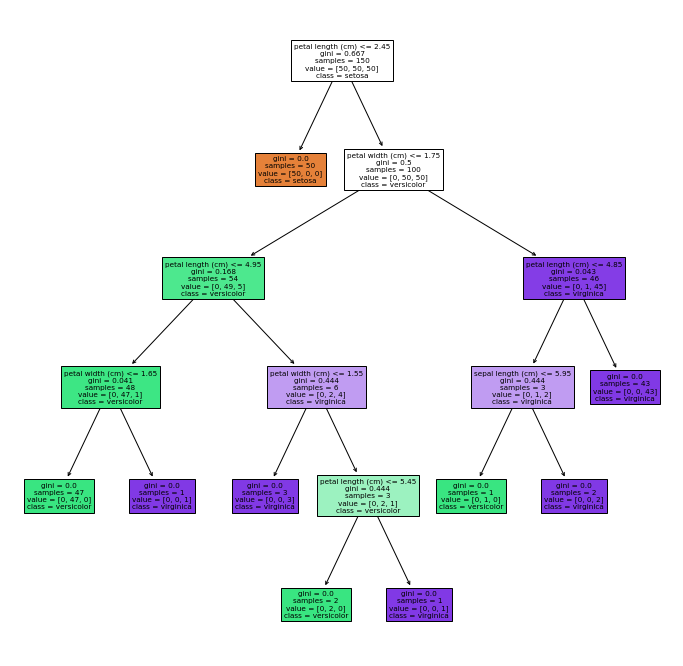

In [80]:
plt.figure(figsize=(12,12))
plot_tree(clf, feature_names=iris.feature_names, 
          class_names=iris.target_names,
         filled=True);

- **Seuil** : on peut lire le nom de la variable discriminante et sa valeur (pour notre cas, il s'agit de la longueur de la pétale qui est inférieur à 2,35 cm). 
- **Gini** : le coefficient de GINI du noeud parent
- **Samples** : fait référence à la taille de l'échantillon
- **Value** : fait référence à la taille de l'échantilllon pour chacune des classes.
- **Class** : fait référence à la classe majoritaire lors de cette embranchement.

# Référence 

[TowardsDataScience, Decision Tree from scratch in python](https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775)